In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import tifffile
import cv2
import random
import datetime
import time
from functools import partial
import ot

from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap, QImage, QPainter, QPen, QColor, QFont, QPainterPath, QBrush
from PyQt5.QtCore import Qt, QTimer, QItemSelection
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
# 親ディレクトリのパスを取得
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class Suite2pROITrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "SUITE2P_ROI_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager = initManagers(WidgetManager(), ConfigManager(), DataManager(), ControlManager())
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # FileLoadUI用のレイアウト
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # メインUI用のレイアウト
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)

        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        # ファイル読み込み用のUIを追加
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # メインUIのクリア
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # 新しいメインUIの設定
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadFallMat(
                app_key=app_key, 
                path_fall=self.widget_manager.dict_lineedit[f"path_fall_{app_key}"].text(),
                config_manager=self.config_manager
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            
            self.control_manager.table_controls[app_key].setupWidgetROITable(app_key)
            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            self.control_manager.view_controls[app_key].setViewSize()
            
            self.control_manager.initializeSkipROITypes(app_key, self.control_manager.table_controls[app_key].table_columns)

    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """
    "Left/Right Upper"
    # View
    def makeLayoutComponentROIView(self, app_key):
        layout = makeLayoutViewWithZTSlider(self.widget_manager, app_key)
        return layout

    # ROI property label
    def makeLayoutComponentROIPropertyDisplay_Threshold(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIProperty(self.widget_manager, key_label=f"{app_key}_roi_prop"))
        return layout
    
    # ROI display, background image button group, checkbox
    def makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutDislplayCelltype(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{app_key}_display_celltype', 
            table_columns=self.config_manager.table_columns[app_key]
        ))
        layout.addLayout(makeLayoutBGImageTypeDisplay(
            self, 
            self.widget_manager, 
            key_buttongroup=f'{app_key}_im_bg_type'
        ))
        layout.addLayout(makeLayoutROIChooseSkip(
            self.widget_manager, 
            key_checkbox=f'{app_key}', 
            table_columns=self.config_manager.table_columns[app_key]
        ))
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout
    
    # Table, ROI count label, Table Columns Config, Set ROI Celltype, ROICheck IO
    def makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutTableROICountLabel(
            self.widget_manager, 
            key_label=app_key, 
            key_table=app_key, 
            table_columns=self.config_manager.table_columns[app_key]
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton(key=f"{app_key}_config_table", label="Table Columns Config"))
        layout.addLayout(makeLayoutROICheckIO(
            self.widget_manager, 
            key_button_save=f"roicheck_save_{app_key}",
            key_button_load=f"roicheck_load_{app_key}",
        ))
        return layout

    def makeLayoutComponent_View_Label_Radiobutton_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentROIView(app_key))
        layout.addLayout(self.makeLayoutComponentROIPropertyDisplay_Threshold(app_key))
        layout.addLayout(self.makeLayoutComponentROIDisplay_BGImageDisplay_ROISkip(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    def makeLayoutComponent_Table_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentTable_ROICountLabel_ROISetSameCelltype_ROICheckIO(app_key))
        return layout

    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutFallRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",    
            f"elastix_config", 
            f"elastix_run",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_im_bg",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        layout.addWidget(self.widget_manager.makeWidgetButton(key="save_reg_roi_bg", label="Save registered ROI and images"))
        layout.addWidget(self.widget_manager.makeWidgetButton(key="load_reg_roi_bg", label="Load registered ROI and images"))
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout

    "Bottom"
    # ファイル読み込み用UI Layout
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_fall", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        for app_key in self.app_keys:
            list_label = [f"Fall mat file path ({app_key} Image)"]
            list_key = [f"path_fall_{app_key}"]
            for label, key in zip(list_label, list_key):
                layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label=label, key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Label_Radiobutton_Slider(self.app_keys[0]))
        layout.addLayout(self.makeLayoutComponent_Table_Button(self.app_keys[0]))
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Label_Radiobutton_Slider(self.app_keys[1]))
        layout.addLayout(self.makeLayoutComponent_Table_Button(self.app_keys[1]))
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    # Table Column Config Dialog
    def showSubWindowTableColumnConfig(self, app_key):
        config_window = TableColumnConfigDialog(
            self, 
            self.control_manager.table_controls[app_key].table_columns, 
            self.config_manager.gui_defaults
        )
        if config_window.exec_():
            self.loadFilePathsandInitialize()

    # Elastix Params Config Dialog
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    # ROI Matching Test Dialog
    def showSubWindowROIMatchingTest(self):
        config_window = ROIMatchingTestDialog(
            self, 
            self.config_manager.gui_defaults,
            self.data_manager,
            self.config_manager,
            self.control_manager,
            self.app_keys[0],
            self.app_keys[1],
            self.control_manager.view_controls[self.app_keys[0]].getShowRegImROI()
        )
        if config_window.exec_() == QDialog.Accepted:
            pass

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):
        for app_key in self.app_keys:
            list_key = [f"path_fall_{app_key}"]
            list_filetype = ["mat"]
            for key, filetype in zip(list_key, list_filetype):
                bindFuncLoadFileWidget(q_widget=self, q_button=self.widget_manager.dict_button[key], q_lineedit=self.widget_manager.dict_lineedit[key], filetype=filetype)

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # ROICheck save load
            bindFuncROICheckIO(
                q_window=self, 
                q_lineedit=self.widget_manager.dict_lineedit[f"path_fall_{app_key}"], 
                q_button_save=self.widget_manager.dict_button[f"roicheck_save_{app_key}"], 
                q_button_load=self.widget_manager.dict_button[f"roicheck_load_{app_key}"], 
                q_table=self.widget_manager.dict_table[f"{app_key}"], 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key=app_key,
                local_var=False
            )
            # Table Column Config
            self.widget_manager.dict_button[f"{app_key}_config_table"].clicked.connect(
                partial(self.showSubWindowTableColumnConfig, app_key)
            )
            # Radiobutton BGImageType buttonChanged
            bindFuncRadiobuttonBGImageTypeChanged(
                q_buttongroup=self.widget_manager.dict_buttongroup[f"{app_key}_im_bg_type"], 
                view_control=self.control_manager.view_controls[app_key],
            )
            # Radiobutton ROIDisplayType buttonChanged
            bindFuncRadiobuttonDisplayCelltypeChanged(
                q_buttongroup=self.widget_manager.dict_buttongroup[f"{app_key}_display_celltype"], 
                view_control=self.control_manager.view_controls[app_key],
                table_control=self.control_manager.table_controls[app_key],
            )
            # Checkbox ROISkip stateChanged
            bindFuncCheckBoxROIChooseSkip(
                list_q_checkbox=[q_checkbox for key, q_checkbox in self.widget_manager.dict_checkbox.items() if (f"skip_choose_" in key) and (f"{app_key}" in key)],
                control_manager=self.control_manager,
                app_key=app_key,
            )
            # ROICheck Table TableColumn CellType Changed
            bindFuncRadiobuttonOfTableChanged(
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # ROICheck Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )

        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredBGImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_bg'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )

        # Elastix Run
        bindFuncButtonRunElastixForFall(
                self,
                q_button=self.widget_manager.dict_button['elastix_run'],
                data_manager=self.data_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key=self.app_keys[0],
                app_key_sec=self.app_keys[1],
                combobox_elastix_method=self.widget_manager.dict_combobox['elastix_method'],
                path_points_txt="points_tmp.txt",
                output_directory="./elastix"
        ) 
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # Registerd ROI and images IO
        bindFuncRegisteredROIAndBGImageIO(
            q_button_save=self.widget_manager.dict_button['save_reg_roi_bg'],
            q_button_load=self.widget_manager.dict_button['load_reg_roi_bg'],
            q_window=self,
            q_lineedit=self.widget_manager.dict_lineedit[f"path_fall_{self.app_keys[1]}"],
            data_manager=self.data_manager,
            app_key=self.app_keys[1],
        )
        # ROI Tracking IO
        bindFuncROITrackingIO(
            q_window=self,
            q_button_save=self.widget_manager.dict_button['roi_matching_save'],
            q_button_load=self.widget_manager.dict_button['roi_matching_load'],
            q_lineedit_pri=self.widget_manager.dict_lineedit[f'path_fall_{self.app_keys[0]}'],
            q_lineedit_sec=self.widget_manager.dict_lineedit[f'path_fall_{self.app_keys[1]}'],
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # ROI Matching Run
        bindFuncButtonRunROIMatching(
            self,
            q_button=self.widget_manager.dict_button['ot_run'],
            q_buttongroup_celltype_pri=self.widget_manager.dict_buttongroup[f"{self.app_keys[0]}_display_celltype"],
            q_buttongroup_celltype_sec=self.widget_manager.dict_buttongroup[f"{self.app_keys[1]}_display_celltype"],
            widget_manager=self.widget_manager,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # Clear ROI Matching result
        bindFuncButtonClearColumnCells(
            q_button=self.widget_manager.dict_button['ot_clear'],
            q_table=self.widget_manager.dict_table[self.app_keys[0]],
            idx_col=self.config_manager.table_columns[self.app_keys[0]].getColumns()["Cell_ID_Match"]["order"], # hardcoded !!!
        )
        # ROI Matching Test
        self.widget_manager.dict_button[f"roi_matching_test"].clicked.connect(
            lambda: self.showSubWindowROIMatchingTest()
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = Suite2pROITrackingGUI()
    gui.show()
    sys.exit(app.exec_())

KeyError: 'dict_img_bg_reg'

1000000000000.0 1.0 999204179080.1149 28199070710.682552
1000000000000.0 1.0 999204179080.1149 28199070710.682552


SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


<Axes: >

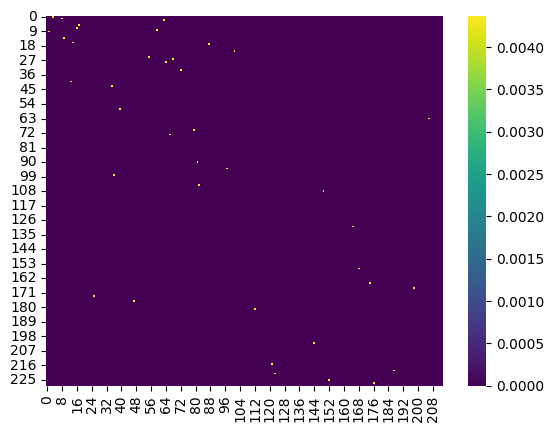

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

dict_ot = gui.dict_ot

G = dict_ot["G"]

sns.heatmap(G, cmap="viridis")

In [10]:
array_src = dict_ot["array_src"]
array_tgt = dict_ot["array_tgt"]
p = dict_ot["p"]
mass = dict_ot["mass"]
reg = dict_ot["reg"]
threshold = dict_ot["threshold"]
max_cost = dict_ot["max_cost"]

In [ ]:
def calculateROIMatching(
        array_src: np.ndarray,
        array_tgt: np.ndarray,
        method: str,
        metric: str="minkowski",
        p: float=2.0,
        mass: float=None,
        reg: float=1.0,
        threshold: float=1e-6,
        max_cost: float=float('inf'),
        return_plan: bool=False # return transport plan matrix
        ) -> Dict[int, int]:
    C = calculateDistanceMatrix(array_src, array_tgt, metric=metric, p=p)
    C1 = calculateDistanceMatrix(array_src, metric=metric, p=p)
    C2 = calculateDistanceMatrix(array_tgt, metric=metric, p=p)
    a = getUniformWeight(len(array_src))
    b = getUniformWeight(len(array_tgt))

    # filter cost matrix with max_cost
    d_constant = 1e12
    C[C > max_cost] = d_constant
    print(np.max(C), np.min(C), np.mean(C), np.std(C))

    G = getOptimalTransportPlan(C, C1, C2, a, b, method, mass, reg)
    if return_plan:
        return G
    else:
        matches = getOneToOneMatching(G, C, threshold, max_cost)
        return matches

In [13]:
path_roi_img_reg = "D:/optic/data/from_saito/cellpose_XYCT/Microgliatracking_AVG_MDA50_LD1_crop_2.mat"

mat_roi_img_reg = loadmat(path_roi_img_reg, simplify_cells=True)
mat_roi = mat_roi_img_reg["ROI"]["save_250206_170754"]["ROICoords"]

In [16]:
mat_roi[0]

array([<scipy.io.matlab._mio5_params.mat_struct object at 0x000001B1768637C0>,
      dtype=object)

In [6]:
def convertMatROICoordsToDictROICoords(mat_roi_coords: Dict[int, Any]):
    dict_roi_coords = {}
    for roi in range(len(mat_roi_coords)):
        if not isinstance(mat_roi_coords[roi], np.ndarray): # if roi itself is empty, the value is np.array([])
            dict_roi_coords[roi] = {}
            for fieldname in mat_roi_coords[roi]._fieldnames: # convert mat_struct to dict
                attr = getattr(mat_roi_coords[roi], fieldname)
                if fieldname in ["xpix", "ypix"] and isinstance(attr, int): # if npix of ROI is 1, the value is int
                    attr = np.array([attr]) # convert int to np.array
                dict_roi_coords[roi][fieldname] = attr
    return dict_roi_coords

mat_roi_coords_reg

[{'xpix': array([367, 378, 379, 380, 367, 368, 369, 376, 377, 378, 379, 380, 381,
         382, 383, 368, 369, 370, 371, 375, 376, 377, 378, 379, 380, 381,
         382, 383, 384, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
         379, 380, 381, 382, 383, 384, 385, 370, 371, 372, 373, 374, 375,
         376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 372, 373,
         374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
         373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
         386, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
         385, 386, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
         385, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 376,
         377, 378, 379, 380, 381, 382, 383, 384, 377, 378, 379, 380, 381,
         382, 383, 384, 378, 379, 380, 381, 382, 383, 379, 380, 381]),
  'ypix': array([211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212,
         212, 212, 213, 2

In [37]:
# mat_microglia_tracking -> dict_roi_matching, dict_roi_coords_xyct
def convertMatMicrogliaTrackingToDictROIMatchingAndDictROICoords(
    mat_microglia_tracking: Dict[str, Any],
) -> Tuple[Dict[Literal["id", "match"], Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]], Dict[int, Dict[int, Dict[Literal["xpix", "ypix", "med"], np.ndarray[np.int32]]]], Dict[int, Dict[int, Dict[Literal["xpix", "ypix", "med"], np.ndarray[np.int32]]]]]:
    mat_roi_matching = mat_microglia_tracking["ROITracking"]
    mat_roi_coords = mat_microglia_tracking["ROICoords"]
    mat_roi_coords_reg = mat_microglia_tracking["ROICoordsRegistered"]

    # convert dict_roi_matching for the GUI
    dict_roi_matching = convertMatROIMatchingToDictROIMatching(mat_roi_matching)
    # convert dict_roi_coords for the GUI
    dict_roi_coords_xyct = convertMatROICoordsXYCTToDictROICoordsXYCT(mat_roi_coords)
    # convert dict_roi_coords_reg for the GUI
    dict_roi_coords_xyct_reg = convertMatROICoordsXYCTToDictROICoordsXYCT(mat_roi_coords_reg)

    return dict_roi_matching, dict_roi_coords_xyct, dict_roi_coords_xyct_reg

# convert mat_roi_coords to dict_roi_coords
def convertMatROICoordsToDictROICoords(mat_roi_coords: Dict[int, Any]) -> Dict[int, Dict[Literal["xpix", "ypix", "med"], np.ndarray[np.int32]]]:
    dict_roi_coords = {}
    for roi in range(len(mat_roi_coords)):
        if not isinstance(mat_roi_coords[roi], np.ndarray): # if roi itself is empty, the value is np.array([])
            dict_roi_coords[roi] = {}
            for fieldname in mat_roi_coords[roi]._fieldnames: # convert mat_struct to dict
                attr = getattr(mat_roi_coords[roi], fieldname)
                if fieldname in ["xpix", "ypix"] and isinstance(attr, int): # if npix of ROI is 1, the value is int
                    attr = np.array([attr]) # convert int to np.array
                dict_roi_coords[roi][fieldname] = attr
    return dict_roi_coords

# multi t_plane
# convert mat_roi_coords to dict_roi_coords
def convertMatROICoordsXYCTToDictROICoordsXYCT(mat_roi_coords_xyct: Dict[int, Dict[int, Any]]) -> Dict[int, Dict[int, Dict[Literal["xpix", "ypix", "med"], np.ndarray[np.int32]]]]:
    dict_roi_coords_xyct = {}
    for t_plane in range(len(mat_roi_coords_xyct)):
        dict_roi_coords_xyct[t_plane] = convertMatROICoordsToDictROICoords(mat_roi_coords_xyct[t_plane])
    return dict_roi_coords_xyct

# convert mat_roi_matching to dict_roi_matching
def convertMatROIMatchingToDictROIMatching(mat_roi_matching: Dict[Literal["id", "match"], np.ndarray]) -> Dict[Literal["id", "match"], Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]]:
    dict_roi_matching_id = {t_plane: mat_roi_matching["id"][t_plane].tolist() for t_plane in range(len(mat_roi_matching["id"]))}
    dict_roi_matching_match = {}

    mat_roi_matching_match = mat_roi_matching["match"]
    for t_plane_pri in range(len(mat_roi_matching_match)):
        dict_roi_matching_match[t_plane_pri] = {}
        mat_roi_matching_match_pri = mat_roi_matching_match[t_plane_pri]
        if mat_roi_matching_match_pri.ndim == 1: # length of last array is 1
            mat_roi_matching_match_pri = mat_roi_matching_match_pri.reshape(1, -1)
        for t_plane_sec in range(len(mat_roi_matching_match_pri)):
            dict_roi_matching_match[t_plane_pri][t_plane_sec + t_plane_pri + 1] = {}
            for roi_pri in range(len(mat_roi_matching_match_pri[t_plane_sec])):
                roi_sec = mat_roi_matching_match_pri[t_plane_sec][roi_pri]
                if isinstance(roi_sec, int): # if roi itself is empty, the valus is np.array([])
                    if roi_sec == -1: # if match roi id is None, the value is -1
                        roi_sec = None
                    dict_roi_matching_match[t_plane_pri][t_plane_sec + t_plane_pri + 1][roi_pri] = roi_sec
    dict_roi_matching = {"id": dict_roi_matching_id, "match": dict_roi_matching_match}
    return dict_roi_matching